 Variational Autoencoder




In [1]:
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.autograd import Variable
from tqdm.auto import tqdm, trange

%matplotlib inline

In [2]:
LOG_INTERVAL = 200

BATCH_SIZE = 128
LEARNING_RATE = 5e-5

CUDA = True
device = torch.device("cuda" if CUDA else "cpu")
print (device)

cuda


In [3]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 1) Helper functions

In [20]:
def show(images, rows=1):
    """
    This function gets multiple MNIST images and plots them in the given number
    of rows.
    """
    rows = int(rows)
    if images.shape[-1] == 784 or images.shape[1] == 1:
        images = images.reshape(-1, 28, 28)

    cols = np.ceil(images.shape[0] / rows)
    plt.rcParams['figure.figsize'] = (cols, rows)

    for i in range(images.shape[0]):
        plt.subplot(rows, int(cols), i + 1)
        plt.imshow(images[i], cmap="gray", vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

## 2) Loading dataset

In [5]:
# Get MNIST dataloader

data_loader_kwargs = {
    'batch_size': BATCH_SIZE,
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 4,
}

train_dataset = datasets.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, **data_loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **data_loader_kwargs)

print(train_dataset.data.max().item())  # But when using `train_loader` your data is normalized, learn more about transforms.ToTensor

100%|██████████| 9912422/9912422 [00:00<00:00, 131961668.27it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105061312.94it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 36953734.42it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16117198.62it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

255


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 3) Models

### 3.1) Autoencoder

In [6]:
# This class defines an Autoencoder
class AE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(AE, self).__init__()

        self.type_str = 'AE'
        self.z_dim = z_dim
        self.dropout = nn.Dropout(p=0.2)

        # Encoder part

        encoder_layers = list()

        dim = input_dim/(encoder_dims+1)
        self.dim_size = [int(dim *(encoder_dims + 1 - i)) for i in range (encoder_dims + 1) ]
        for i in range (encoder_dims):
          encoder_layers.append( nn.Linear(self.dim_size[i] , self.dim_size[i+1]).to(device))
          encoder_layers.append(nn.ReLU(True))

        pass

        self.encoder = nn.Sequential(*encoder_layers)


        self.z_layer = None

        self.z_layer = nn.Linear(self.dim_size[-1]  , z_dim).to(device)
        pass



        decoder_layers = list()

        dim = input_dim / (decoder_dims)
        dec_size = [int(dim *(i+1)) for i in range (decoder_dims) ]
        for i in range (decoder_dims):
          if i == 0 :
            decoder_layers.append(nn.Linear(z_dim , dec_size[i] ).to(device))
            decoder_layers.append(nn.ReLU(True).to(device))
          elif i < decoder_dims-1:
            decoder_layers.append(nn.Linear( dec_size[i-1] , dec_size[i]).to(device))
            decoder_layers.append(nn.ReLU(True).to(device))

          else:
            decoder_layers.append(nn.Linear(dec_size[i-1] , dec_size[i]) .to(device))
        pass

        self.decoder = nn.Sequential(*decoder_layers)



    def forward(self, x):
        x_hat, z = None, None
        dropped_out = self.dropout(x)

        encode = self.encoder(x)
        z = self.z_layer(encode)
        x_hat = self.decoder(z)
        pass
        return x_hat, z, None  # Last output is returned for the sake of compatibility

    def get_loss(self, x, x_hat, *_):

        loss_func = nn.MSELoss()
        loss = loss_func(x , x_hat)
        return loss
        pass



### 3.2) Variational Autoencoder

In [7]:
# This class defines a Variationl Autoencoder
# It inherits the AE class
class VAE(AE):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(VAE, self).__init__(input_dim, encoder_dims, z_dim, decoder_dims)

        self.type_str = 'VAE'
        del self.z_layer  # z_layer is not needed anymore

        # Drouput, Encoder, and Decoder have been defined in AE class

        # mu and sigma_matrix part
        self.mu_layer, self.logvar_layer = None, None

        self.mu_layer = nn.Linear(self.dim_size[-1] , z_dim).to(device)
        self.logvar_layer = nn.Linear(self.dim_size[-1] , z_dim).to(device)
        pass


    @staticmethod
    def reparameterize(mu, logvar):
        z = None


        std = torch.exp(logvar/2)
        eps = Variable(std.data.new(std.size()).normal_())
        z = eps.mul(std).add_(mu)

        pass
        return z

    def forward(self, x):
        x_hat, mu, logvar = None, None, None
        dropped_out = self.dropout(x)

        encode = self.encoder(x)
        mu = self.mu_layer(encode)
        logvar = self.logvar_layer(encode)
        z = self.reparameterize(mu , logvar)
        x_hat = self.decoder(z)
        pass
        return x_hat, mu, logvar

    def get_loss(self, x, x_hat, mu, logvar):
        MSE, KLD = 0, 0

        loss_func = nn.MSELoss(reduction= 'sum')
        MSE = loss_func(x , x_hat)
        KLD = -0.5 * torch.sum(1 + logvar - mu**2 -torch.exp(logvar))
        pass
        return MSE + KLD

    def generate(self, n):
        samples = None

        shape = torch.ones(self.dim_size[-1] , self.z_dim)
        randoms = [torch.randn_like(shape[0] , device= device) for _ in range (n)]
        randoms = torch.stack(randoms)
        samples = self.decoder(randoms)
        pass
        return samples

## 4) Run

### 4.1) Required functions

In [8]:
def train(model, optimizer, verbose=True):
    """
    This function trains a `model` on `train_loader` for 1 epoch and prints the
    loss value
    """
    model.train()
    train_loss = 0

    for batch_idx, (x, _) in enumerate(tqdm(train_loader, desc='Batches', leave=False)):
        x = x.flatten(start_dim=1).to(device)

        optimizer.zero_grad()

        x_hat, mu, logvar = model(x)
        loss = model.get_loss(x, x_hat, mu, logvar)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        if verbose and batch_idx % LOG_INTERVAL == LOG_INTERVAL-1:
            print('    Train [%d/%d]\t | \tLoss: %.5f' % (batch_idx * x.shape[0], len(train_loader.dataset), loss.item() / x.shape[0]))

    train_loss /= len(train_loader.dataset)
    if verbose:
        print('==> Train | Average loss: %.4f' % train_loss)

In [9]:
def test(model, verbose=True):
    """
    This function tests a `model` on a `test_loader` and prints the loss value
    """
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.flatten(start_dim=1).to(device)

            x_hat, mu, logvar = model(x)
            loss = model.get_loss(x, x_hat, mu, logvar)
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    if verbose:
        print('==> Test  | Average loss: %.4f' % test_loss)

In [10]:
def run(model, n_epoch, verbose=True):
    """
    This function will optimize parameters of `model` for `n_epoch` epochs
    on `train_loader` and validate it on `test_loader`.
    """

    model.to(device)
    pass

    optimizer = None

    optimizer = optim.Adam(model.parameters() , lr = 0.001)
    pass

    for epoch in trange(1, n_epoch+1, desc='Epochs', leave=True):
        if verbose:
            print('\nEpoch %d:' % epoch)
        train(model, optimizer, verbose)
        test(model, verbose)

### 4.2) Do run

In [11]:
ae_low_dim, vae_low_dim, ae_high_dim, vae_high_dim = 4 * [None]

ae_low_dim  = AE(28*28  , 3 , 2 , 3)
vae_low_dim = VAE(28*28  , 3 , 2 , 3)
ae_high_dim = AE(28*28  , 3 , 20 , 3)
vae_high_dim = VAE(28*28  , 3 , 20 , 3)
run(ae_low_dim , 30)
run(vae_low_dim , 30)
run(ae_high_dim , 50)
run(vae_high_dim , 50)
pass

models = [ae_low_dim, vae_low_dim, ae_high_dim, vae_high_dim]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00038
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0004
==> Test  | Average loss: 0.0003

Epoch 2:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 3:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00030
    Train [51072/60000]	 | 	Loss: 0.00031
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 4:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1424, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.10/threading.py", line 1093, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, i

    Train [25472/60000]	 | 	Loss: 0.00033
    Train [51072/60000]	 | 	Loss: 0.00031
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 5:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00029
    Train [51072/60000]	 | 	Loss: 0.00030
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 6:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00029
    Train [51072/60000]	 | 	Loss: 0.00030
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 7:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00028
    Train [51072/60000]	 | 	Loss: 0.00030
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 8:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00027
    Train [51072/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 9:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

    Train [25472/60000]	 | 	Loss: 0.00028
    Train [51072/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 10:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00028
    Train [51072/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 11:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00030
    Train [51072/60000]	 | 	Loss: 0.00025
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 12:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00029
    Train [51072/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 13:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00024
    Train [51072/60000]	 | 	Loss: 0.00028
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 14:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00027
    Train [51072/60000]	 | 	Loss: 0.00029
==> Train | Average loss: 0.0003


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

==> Test  | Average loss: 0.0003

Epoch 15:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
if w.is_alive():    
  File "/usr/lib/

    Train [25472/60000]	 | 	Loss: 0.00029
    Train [51072/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 16:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00027
    Train [51072/60000]	 | 	Loss: 0.00026
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 17:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00028
    Train [51072/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 18:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00029
    Train [51072/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 19:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00027
    Train [51072/60000]	 | 	Loss: 0.00024
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 20:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00028
    Train [51072/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 21:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00027
    Train [51072/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 22:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00028
    Train [51072/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 23:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00026
    Train [51072/60000]	 | 	Loss: 0.00028
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 24:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00024
    Train [51072/60000]	 | 	Loss: 0.00026
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 25:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00027
    Train [51072/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 26:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00024
    Train [51072/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 27:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00027
    Train [51072/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 28:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00027
    Train [51072/60000]	 | 	Loss: 0.00028
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 29:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00028
    Train [51072/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0003

Epoch 30:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00025
    Train [51072/60000]	 | 	Loss: 0.00026
==> Train | Average loss: 0.0003


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Exception ignored in: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a

==> Test  | Average loss: 0.0003


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

    Train [25472/60000]	 | 	Loss: 44.76818
    Train [51072/60000]	 | 	Loss: 43.00745
==> Train | Average loss: 45.3326
==> Test  | Average loss: 40.6944

Epoch 2:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 38.97477
    Train [51072/60000]	 | 	Loss: 39.24148
==> Train | Average loss: 39.4329
==> Test  | Average loss: 39.0036

Epoch 3:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 39.55297
    Train [51072/60000]	 | 	Loss: 38.36958
==> Train | Average loss: 38.1478
==> Test  | Average loss: 38.0372

Epoch 4:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 37.56275
    Train [51072/60000]	 | 	Loss: 37.05139
==> Train | Average loss: 37.4525
==> Test  | Average loss: 37.3749

Epoch 5:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 37.11098
    Train [51072/60000]	 | 	Loss: 38.41998
==> Train | Average loss: 36.8939
==> Test  | Average loss: 36.6226

Epoch 6:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Exception ignored in: Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.

    Train [25472/60000]	 | 	Loss: 36.32515
    Train [51072/60000]	 | 	Loss: 35.79009
==> Train | Average loss: 36.4495
==> Test  | Average loss: 36.2158

Epoch 7:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 37.92201
    Train [51072/60000]	 | 	Loss: 33.45068
==> Train | Average loss: 36.1362
==> Test  | Average loss: 36.1077

Epoch 8:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 34.98199
    Train [51072/60000]	 | 	Loss: 37.95628
==> Train | Average loss: 35.8883
==> Test  | Average loss: 36.0195

Epoch 9:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 34.43803
    Train [51072/60000]	 | 	Loss: 34.27819
==> Train | Average loss: 35.5687
==> Test  | Average loss: 35.5955

Epoch 10:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 35.40277
    Train [51072/60000]	 | 	Loss: 34.68979
==> Train | Average loss: 35.3167
==> Test  | Average loss: 35.6193

Epoch 11:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
can only test a child processAssertionError: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del_

    Train [25472/60000]	 | 	Loss: 35.68989
    Train [51072/60000]	 | 	Loss: 35.36502
==> Train | Average loss: 35.1819
==> Test  | Average loss: 35.1997

Epoch 12:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 35.57616
    Train [51072/60000]	 | 	Loss: 35.79385
==> Train | Average loss: 35.0024
==> Test  | Average loss: 35.2240

Epoch 13:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 35.84561
    Train [51072/60000]	 | 	Loss: 34.21116
==> Train | Average loss: 34.8859
==> Test  | Average loss: 35.0554

Epoch 14:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 34.36550
    Train [51072/60000]	 | 	Loss: 33.65137
==> Train | Average loss: 34.7470
==> Test  | Average loss: 34.9108

Epoch 15:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 32.41550
    Train [51072/60000]	 | 	Loss: 35.49915
==> Train | Average loss: 34.5805
==> Test  | Average loss: 34.8406

Epoch 16:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
:     can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: <function _M

    Train [25472/60000]	 | 	Loss: 32.31569
    Train [51072/60000]	 | 	Loss: 34.96681
==> Train | Average loss: 34.5497
==> Test  | Average loss: 34.5887

Epoch 17:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 34.70811
    Train [51072/60000]	 | 	Loss: 33.72755
==> Train | Average loss: 34.4863
==> Test  | Average loss: 34.5496

Epoch 18:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 32.58021
    Train [51072/60000]	 | 	Loss: 35.93362
==> Train | Average loss: 34.3802
==> Test  | Average loss: 34.7617

Epoch 19:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 36.48649
    Train [51072/60000]	 | 	Loss: 33.81113
==> Train | Average loss: 34.2603
==> Test  | Average loss: 34.4550

Epoch 20:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 34.57073
    Train [51072/60000]	 | 	Loss: 32.80011
==> Train | Average loss: 34.2787
==> Test  | Average loss: 34.4398

Epoch 21:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

    Train [25472/60000]	 | 	Loss: 33.59416
    Train [51072/60000]	 | 	Loss: 35.20358
==> Train | Average loss: 34.1876
==> Test  | Average loss: 34.3297

Epoch 22:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 32.56538
    Train [51072/60000]	 | 	Loss: 32.88850
==> Train | Average loss: 34.1203
==> Test  | Average loss: 34.3175

Epoch 23:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 33.58797
    Train [51072/60000]	 | 	Loss: 34.59096
==> Train | Average loss: 34.1012
==> Test  | Average loss: 34.3926

Epoch 24:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 34.58100
    Train [51072/60000]	 | 	Loss: 31.41235
==> Train | Average loss: 33.9689
==> Test  | Average loss: 34.1987

Epoch 25:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 32.35936
    Train [51072/60000]	 | 	Loss: 33.91204
==> Train | Average loss: 33.9298
==> Test  | Average loss: 34.4228

Epoch 26:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 32.54735
    Train [51072/60000]	 | 	Loss: 32.38861
==> Train | Average loss: 33.8723


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

Exception ignored in:       File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File 

==> Test  | Average loss: 34.2671

Epoch 27:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 34.57743
    Train [51072/60000]	 | 	Loss: 33.92365
==> Train | Average loss: 33.8723
==> Test  | Average loss: 34.1941

Epoch 28:


Batches:   0%|          | 0/469 [00:10<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 34.35682
    Train [51072/60000]	 | 	Loss: 33.90573
==> Train | Average loss: 33.9365
==> Test  | Average loss: 34.2038

Epoch 29:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 33.91034
    Train [51072/60000]	 | 	Loss: 33.09421
==> Train | Average loss: 33.8626
==> Test  | Average loss: 34.1805

Epoch 30:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 32.02775
    Train [51072/60000]	 | 	Loss: 35.10130
==> Train | Average loss: 33.9142
==> Test  | Average loss: 34.3142


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00026
    Train [51072/60000]	 | 	Loss: 0.00018
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0002

Epoch 2:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
can only test a child processTraceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/pyth

    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 3:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 4:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00011
    Train [51072/60000]	 | 	Loss: 0.00011
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 5:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00010
    Train [51072/60000]	 | 	Loss: 0.00010
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 6:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00010
    Train [51072/60000]	 | 	Loss: 0.00010
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 7:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00008
    Train [51072/60000]	 | 	Loss: 0.00009
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 8:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00009
    Train [51072/60000]	 | 	Loss: 0.00009
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 9:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00009
    Train [51072/60000]	 | 	Loss: 0.00009
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 10:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00009
    Train [51072/60000]	 | 	Loss: 0.00008
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 11:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00008
    Train [51072/60000]	 | 	Loss: 0.00008
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 12:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>    if w.is_alive():if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    

assert self._parent_pid == os.getpid(), 'can 

    Train [25472/60000]	 | 	Loss: 0.00008
    Train [51072/60000]	 | 	Loss: 0.00008
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 13:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00008
    Train [51072/60000]	 | 	Loss: 0.00008
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 14:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 15:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 16:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00008
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 17:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Traceback (most recent call last):

Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()Traceback (most recent call last):

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    self._shutdown_workers()    if w.is_alive

    Train [25472/60000]	 | 	Loss: 0.00008
    Train [51072/60000]	 | 	Loss: 0.00008
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 18:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00008
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 19:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 20:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 21:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 22:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 23:


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>

<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

Batches:   0%|          | 0/469 [00:01<?, ?it/s]


if w.is_alive():
: AssertionError  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>AssertionError: 
Traceback (most recent call last):
can only test a child process
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 24:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 25:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 26:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 27:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>AssertionError: can only test a child process

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tor

==> Test  | Average loss: 0.0001

Epoch 28:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: Traceback (most recent call last):
self._shutdown_workers()Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__


  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 29:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 30:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 31:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 32:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 33:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 34:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 35:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 36:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 37:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 38:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__


        Traceback (most recent call last):
Traceback (most recent call last):
self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

  File "/usr/local/lib/python3

==> Test  | Average loss: 0.0001

Epoch 39:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 40:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 41:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 42:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 43:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00007
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    

Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/

==> Test  | Average loss: 0.0001

Epoch 44:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440><function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>

<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
          File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()self._shutdown_workers()    

Exception ignored in: self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in 

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 45:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00007
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 46:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 47:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 48:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00005
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440><function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440><function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Exception ignored in: 
Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()Traceback (most recent call last):
self._shutdown_wo

==> Test  | Average loss: 0.0001

Epoch 49:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 50:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 0.00006
    Train [51072/60000]	 | 	Loss: 0.00006
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 51.17366
    Train [51072/60000]	 | 	Loss: 42.41598
==> Train | Average loss: 48.9215
==> Test  | Average loss: 43.5687

Epoch 2:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 40.69864
    Train [51072/60000]	 | 	Loss: 40.87633
==> Train | Average loss: 40.6279
==> Test  | Average loss: 38.7375

Epoch 3:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>    <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>  File "/usr/local/lib

    Train [25472/60000]	 | 	Loss: 38.72916
    Train [51072/60000]	 | 	Loss: 33.31810
==> Train | Average loss: 37.3803
==> Test  | Average loss: 36.2098

Epoch 4:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 36.67625
    Train [51072/60000]	 | 	Loss: 34.97079
==> Train | Average loss: 35.4668
==> Test  | Average loss: 34.9252

Epoch 5:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 35.11635
    Train [51072/60000]	 | 	Loss: 34.52503
==> Train | Average loss: 34.5166
==> Test  | Average loss: 34.0535

Epoch 6:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 32.85723
    Train [51072/60000]	 | 	Loss: 34.01073
==> Train | Average loss: 33.8425
==> Test  | Average loss: 33.6302

Epoch 7:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 32.24366
    Train [51072/60000]	 | 	Loss: 33.29118
==> Train | Average loss: 33.3829
==> Test  | Average loss: 33.1647

Epoch 8:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()
          File "/usr

    Train [25472/60000]	 | 	Loss: 32.78806
    Train [51072/60000]	 | 	Loss: 33.51625
==> Train | Average loss: 33.0702
==> Test  | Average loss: 32.8970

Epoch 9:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 32.05612
    Train [51072/60000]	 | 	Loss: 34.98552
==> Train | Average loss: 32.8268
==> Test  | Average loss: 32.8472

Epoch 10:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 33.48975
    Train [51072/60000]	 | 	Loss: 33.01790
==> Train | Average loss: 32.6128
==> Test  | Average loss: 32.5332

Epoch 11:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.92513
    Train [51072/60000]	 | 	Loss: 32.60292
==> Train | Average loss: 32.4483
==> Test  | Average loss: 32.4945

Epoch 12:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.80113
    Train [51072/60000]	 | 	Loss: 31.87145
==> Train | Average loss: 32.2857
==> Test  | Average loss: 32.3307

Epoch 13:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.23112
    Train [51072/60000]	 | 	Loss: 32.95310
==> Train | Average loss: 32.1667


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>Traceback (most recent call last):

Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>    
self._shutdown_workers()
Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packag

==> Test  | Average loss: 32.1349

Epoch 14:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.40411
    Train [51072/60000]	 | 	Loss: 31.92567
==> Train | Average loss: 32.0145
==> Test  | Average loss: 32.1089

Epoch 15:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.85696
    Train [51072/60000]	 | 	Loss: 32.55195
==> Train | Average loss: 31.8907
==> Test  | Average loss: 31.8597

Epoch 16:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.18779
    Train [51072/60000]	 | 	Loss: 31.52582
==> Train | Average loss: 31.8126
==> Test  | Average loss: 31.9612

Epoch 17:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.42405
    Train [51072/60000]	 | 	Loss: 31.86031
==> Train | Average loss: 31.7395
==> Test  | Average loss: 31.8019

Epoch 18:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only te

    Train [25472/60000]	 | 	Loss: 29.05068
    Train [51072/60000]	 | 	Loss: 33.31050
==> Train | Average loss: 31.6565
==> Test  | Average loss: 31.7911

Epoch 19:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.62995
    Train [51072/60000]	 | 	Loss: 32.91698
==> Train | Average loss: 31.5805
==> Test  | Average loss: 31.6630

Epoch 20:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.70404
    Train [51072/60000]	 | 	Loss: 31.11512
==> Train | Average loss: 31.4968
==> Test  | Average loss: 31.6129

Epoch 21:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 30.63627
    Train [51072/60000]	 | 	Loss: 30.87589
==> Train | Average loss: 31.4493
==> Test  | Average loss: 31.5890

Epoch 22:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 30.24869
    Train [51072/60000]	 | 	Loss: 31.16370
==> Train | Average loss: 31.3861
==> Test  | Average loss: 31.6559

Epoch 23:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 32.59125
    Train [51072/60000]	 | 	Loss: 31.36097
==> Train | Average loss: 31.3052
==> Test  | Average loss: 31.4549

Epoch 24:


Exception ignored in: 

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440><function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):

Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():    self._shutdown_workers()if

    Train [25472/60000]	 | 	Loss: 31.18430
    Train [51072/60000]	 | 	Loss: 31.01778
==> Train | Average loss: 31.2760


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>    
assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
: can only test a child process    
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>self._shutdown_workers()
<function _MultiProcessingDataLoaderIter

==> Test  | Average loss: 31.4765

Epoch 25:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

    Train [25472/60000]	 | 	Loss: 32.14201
    Train [51072/60000]	 | 	Loss: 30.34614
==> Train | Average loss: 31.2512
==> Test  | Average loss: 31.3437

Epoch 26:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 32.20364
    Train [51072/60000]	 | 	Loss: 33.23874
==> Train | Average loss: 31.1893
==> Test  | Average loss: 31.3316

Epoch 27:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.26263
    Train [51072/60000]	 | 	Loss: 29.96244
==> Train | Average loss: 31.1709
==> Test  | Average loss: 31.4305

Epoch 28:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 29.04865
    Train [51072/60000]	 | 	Loss: 30.87109
==> Train | Average loss: 31.1145
==> Test  | Average loss: 31.3078

Epoch 29:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 30.27148
    Train [51072/60000]	 | 	Loss: 30.55563
==> Train | Average loss: 31.0658
==> Test  | Average loss: 31.3069

Epoch 30:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.23991
    Train [51072/60000]	 | 	Loss: 28.86801
==> Train | Average loss: 31.0466
==> Test  | Average loss: 31.1849

Epoch 31:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.52169
    Train [51072/60000]	 | 	Loss: 31.26882
==> Train | Average loss: 31.0099
==> Test  | Average loss: 31.2493

Epoch 32:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 32.90771
    Train [51072/60000]	 | 	Loss: 29.96192
==> Train | Average loss: 30.9730
==> Test  | Average loss: 31.1540

Epoch 33:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 30.08859
    Train [51072/60000]	 | 	Loss: 30.46073
==> Train | Average loss: 30.9246
==> Test  | Average loss: 31.1653

Epoch 34:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.52753
    Train [51072/60000]	 | 	Loss: 30.33591
==> Train | Average loss: 30.8962


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>    if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>    
Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/pyt

==> Test  | Average loss: 31.1237

Epoch 35:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.84781
    Train [51072/60000]	 | 	Loss: 32.08566
==> Train | Average loss: 30.9044
==> Test  | Average loss: 31.1669

Epoch 36:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 30.23851
    Train [51072/60000]	 | 	Loss: 32.84367
==> Train | Average loss: 30.8567
==> Test  | Average loss: 31.1002

Epoch 37:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 27.24463
    Train [51072/60000]	 | 	Loss: 30.08036
==> Train | Average loss: 30.8317
==> Test  | Average loss: 30.9779

Epoch 38:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 30.95471
    Train [51072/60000]	 | 	Loss: 29.25743
==> Train | Average loss: 30.8187
==> Test  | Average loss: 31.0035

Epoch 39:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 32.00787
    Train [51072/60000]	 | 	Loss: 30.74942
==> Train | Average loss: 30.8020


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

==> Test  | Average loss: 30.9854

Epoch 40:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 33.62507
    Train [51072/60000]	 | 	Loss: 30.47230
==> Train | Average loss: 30.7668
==> Test  | Average loss: 31.0347

Epoch 41:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 30.13591
    Train [51072/60000]	 | 	Loss: 30.30681
==> Train | Average loss: 30.7538
==> Test  | Average loss: 30.9149

Epoch 42:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 29.47892
    Train [51072/60000]	 | 	Loss: 31.27594
==> Train | Average loss: 30.7301
==> Test  | Average loss: 30.9956

Epoch 43:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.26357
    Train [51072/60000]	 | 	Loss: 30.57279
==> Train | Average loss: 30.7060
==> Test  | Average loss: 30.9929

Epoch 44:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 30.24795
    Train [51072/60000]	 | 	Loss: 31.23573
==> Train | Average loss: 30.6955


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

==> Test  | Average loss: 30.9831

Epoch 45:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

    Train [25472/60000]	 | 	Loss: 29.07531
    Train [51072/60000]	 | 	Loss: 31.31893
==> Train | Average loss: 30.6940
==> Test  | Average loss: 31.0369

Epoch 46:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.94289
    Train [51072/60000]	 | 	Loss: 31.48005
==> Train | Average loss: 30.6587
==> Test  | Average loss: 30.9056

Epoch 47:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 31.13488
    Train [51072/60000]	 | 	Loss: 29.09607
==> Train | Average loss: 30.6195
==> Test  | Average loss: 30.8879

Epoch 48:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 30.46712
    Train [51072/60000]	 | 	Loss: 29.07026
==> Train | Average loss: 30.6321
==> Test  | Average loss: 30.9418

Epoch 49:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

    Train [25472/60000]	 | 	Loss: 28.28913
    Train [51072/60000]	 | 	Loss: 31.21102
==> Train | Average loss: 30.6123
==> Test  | Average loss: 30.9559

Epoch 50:


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db39864a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

    Train [25472/60000]	 | 	Loss: 31.85420
    Train [51072/60000]	 | 	Loss: 29.38970
==> Train | Average loss: 30.5967
==> Test  | Average loss: 30.8980


## 5) Results

### 5.1) Representation

AE:


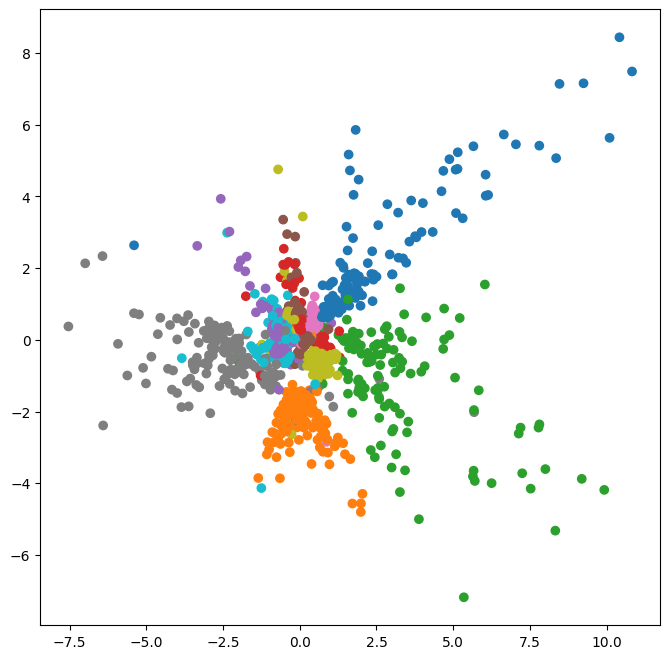


VAE:


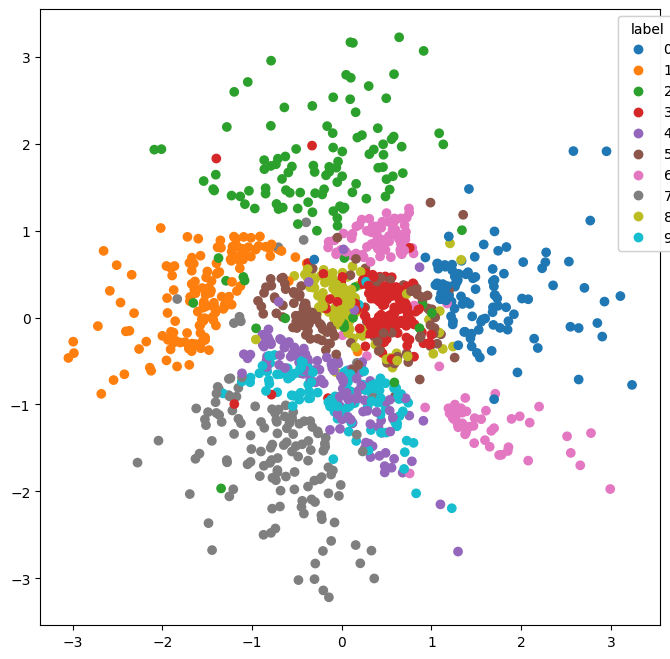

In [12]:


def visualize_2d(model, n_batch):
    assert model.z_dim == 2
    model.eval()

    n = BATCH_SIZE * n_batch
    Y, Z = torch.zeros(n, dtype=int), torch.zeros((n, model.z_dim))

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            if batch_idx >= n_batch:
                break
            current_range = range(batch_idx * BATCH_SIZE, (batch_idx+1) * BATCH_SIZE)
            Y[current_range] = y
            x = x.flatten(start_dim=1).to(device)
            _, z, _ = model(x)
            Z[current_range] = z.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    scatter = ax.scatter(Z[:, 0], Z[:, 1], c=Y, cmap='tab10')
    legend = ax.legend(*scatter.legend_elements(), bbox_to_anchor=(1.04, 1), title="label")
    ax.add_artist(legend)
    plt.show()

print('AE:')
visualize_2d(ae_low_dim, 10)

print('\nVAE:')
visualize_2d(vae_low_dim, 10)

### 5.2) Reconstruction

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Data


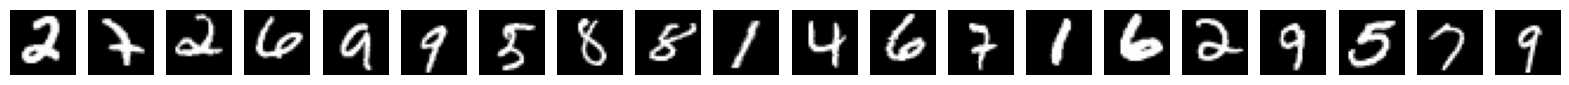

AE 2D


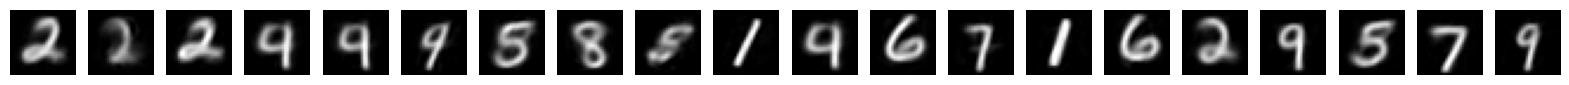

VAE 2D


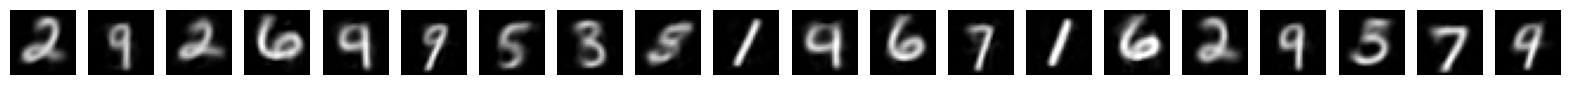

AE 20D


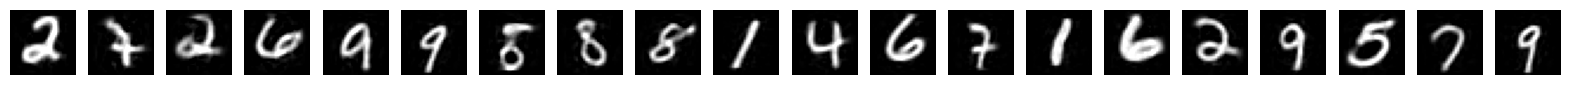

VAE 20D


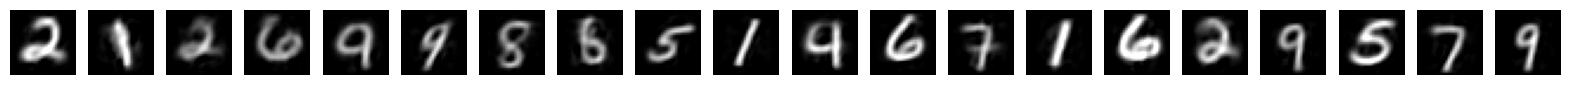

In [21]:
def plot_reconstructions(models, n):
    x = next(iter(test_loader))[0][:n]
    print('Data')
    show(x.squeeze(1))

    x = x.flatten(start_dim=1).to(device)
    for model in models:
        model.eval()
        x_hat, _, _ = model(x)
        print('%s %dD' % (model.type_str, model.z_dim))
        show(x_hat.detach().cpu())

plot_reconstructions(models, 20)



### 5.3) Generation

VAE 20D


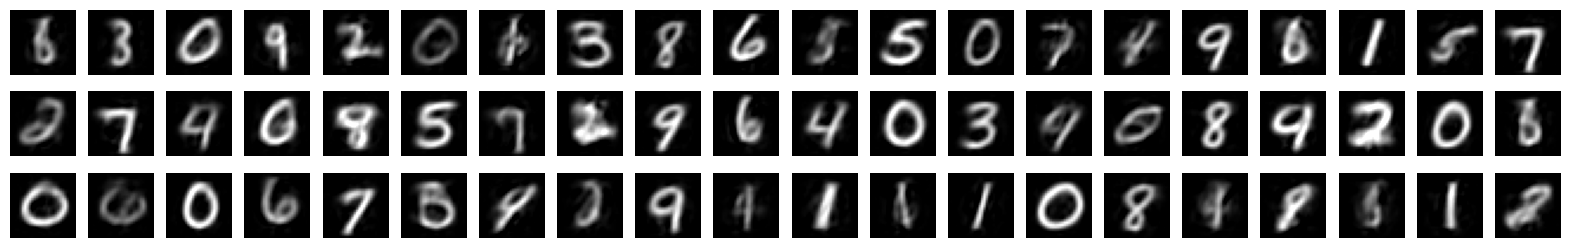

In [22]:
print('VAE %dD' % vae_high_dim.z_dim)
generated_imgs = vae_high_dim.generate(60)
show(generated_imgs.detach().cpu(), 3)



### 5.4) Interpolation

AE 2D


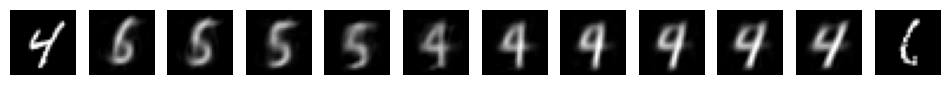

VAE 2D


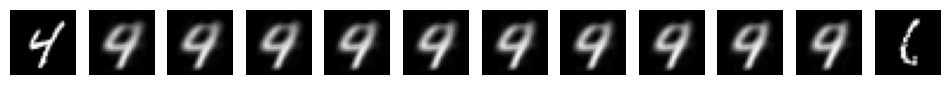

AE 20D


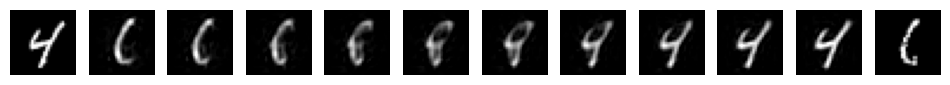

VAE 20D


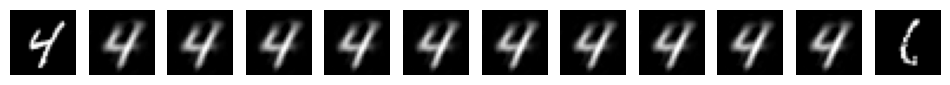

---

AE 2D


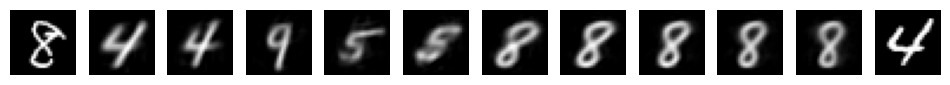

VAE 2D


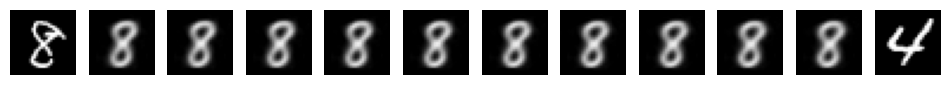

AE 20D


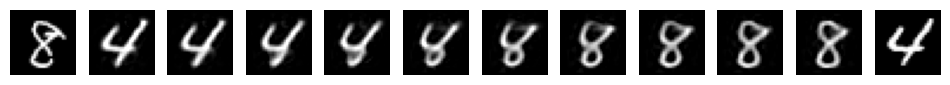

VAE 20D


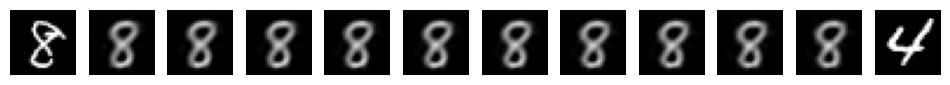

---

AE 2D


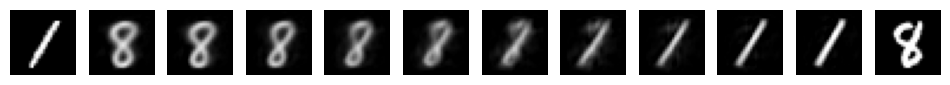

VAE 2D


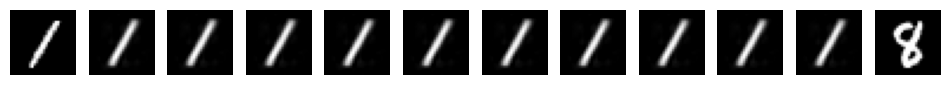

AE 20D


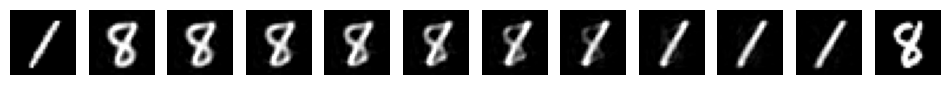

VAE 20D


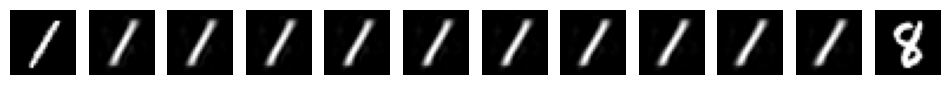

---

AE 2D


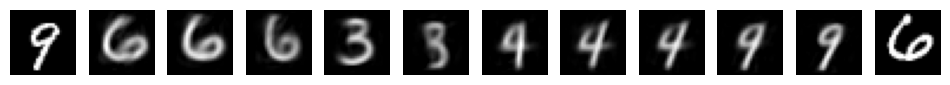

VAE 2D


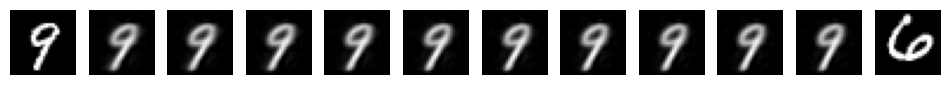

AE 20D


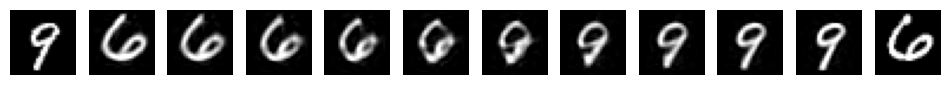

VAE 20D


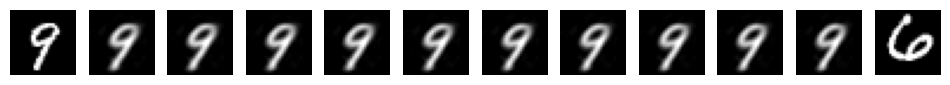

---

AE 2D


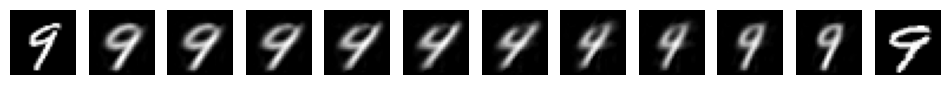

VAE 2D


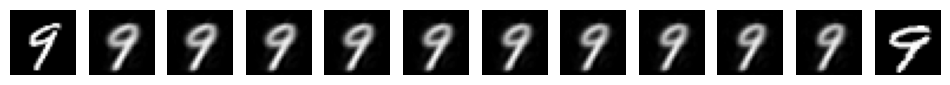

AE 20D


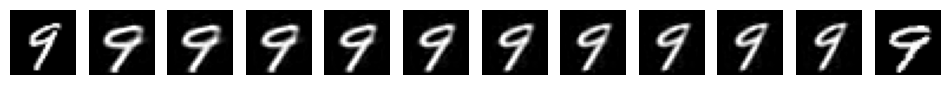

VAE 20D


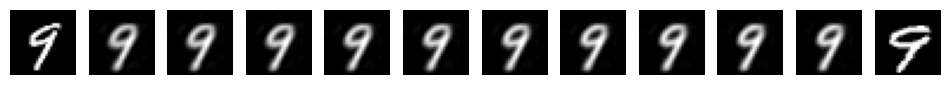

---



In [23]:
def plot_interpolations(models, n_rows, n_cols=10):
    """
    This function interpolates n_cols images between two random MNIST image
    """
    plt.rcParams['figure.figsize'] = (n_cols, n_rows)

    x = next(iter(test_loader))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    for i in range(n_rows):
        img1 = x[2 * i]
        img2 = x[2 * i + 1]

        for model in models:
            model.eval()
            images = None

            encode1 = model.encoder(img1)
            encode2 = model.encoder(img2)
            if (model.type_str == 'AE'):
              z1 = model.z_layer(encode1)
              z2 = model.z_layer(encode2)
            else:
              mu1  , logvar1 = model.mu_layer(encode1) , model.logvar_layer(encode1)
              mu2  , logvar2 = model.mu_layer(encode2) , model.logvar_layer(encode2)
              z1 = model.reparameterize(mu1 , logvar1)
              z2 = model.reparameterize(mu1 , logvar1)

            alpha = torch.linspace(0., 1., 10).to(device)
            alpha = alpha.view(1, 10, 1)

            n_cols = (z1 * alpha + z2 * (1 - alpha))

            images = img1.unsqueeze(0)
            decoder = model.decoder(n_cols).squeeze(0)
            images = torch.cat((images , decoder) , 0)
            images = torch.cat((images , img2.unsqueeze(0)) ,  0)

            images = images.detach().cpu()
            pass
            print('%s %dD' % (model.type_str, model.z_dim))
            show(images)
        print('---\n')

plot_interpolations(models, 5)

